# Control Systems 1, NB11:  Time delays, Successive loop closure, Nonlinearities

© 2024 ETH Zurich, Mark Benazet Castells, Jonas Holinger, Felix Muller, Matteo Penlington; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

This interactive notebook is designed to introduce the fundamental concepts of control systems engineering. It covers time delays, how to approximate them, and their influence on system performance. Additionally, the notebook provides a brief overview of compensators, their effects on system behavior, and how to implement them. Finally, a quick introduction to nonlinearities follows



Authors:
- Jonas Holinger; jholinger@ethz.ch
- Shubham Gupta; shugupta@ethz.ch

# Learning Objectives


After completing this notebook, you should be able to:

1. Understand the effects of time delays on frequency response and stability.
2. Approximate time delays as a proper rational transfer function.
3. Understand the effects of compensators on a system and how to implement them.
4. Grasp the fundamentals of nonlinearities.


In [2]:
%pip install numpy matplotlib scipy ipywidgets control IPython sympy

In [4]:
#@title Import Libraries

import control as ct
import matplotlib.pyplot as plt
import numpy as np
import math
import ipywidgets as widgets
from scipy.integrate import odeint
from IPython.display import display, clear_output, Math
from ipywidgets import interactive, FloatSlider, VBox, ToggleButton, FloatSlider
from scipy import signal
import warnings
warnings.filterwarnings("ignore")

# Motivation

In real-world systems, we often analyze ideal models that are linear and time-invariant (LTI). However, most systems deviate from these idealizations, and real-world controllers are rarely perfect. As a result, it becomes crucial to account for phenomena such as time delays and nonlinearities, which are common in practical systems and can significantly affect their performance.
Compensators can be used to tune a system optimally and are an alternative to the PID controller

# Time Delay
A time delay refers to the phenomenon where there's a delay between the input to the system and its corresponding output response. This delay can occur due to various reasons, such as sensor response time, communication latency in a controller implemented within a computer, or physical delays, like water traveling inside a pipe when the shower is turned on.

We want to account for the effects of time delays. The time delay operator, which transforms an input signal $ u(t) $ into a delayed output $ y(t) = u(t-T) $ with a delay of $ T $ seconds, is represented in the Laplace domain as:
$$e^{-sT}$$  

### Example
Consider a first-order system of the form $ G(s) = \frac{5}{s+3} $. We want to add a time delay of 4 seconds. The new transfer function becomes:
$$G(s) = \frac{5}{s+3}e^{-4s}$$

The time delay operator is a linear operator, but the resulting transfer function is not rational, which means we cannot apply the root-locus method. Additionally, a time delay can make a system unstable.


In [32]:
def plot_step_response_delay(wn, zeta, delay):

    num = [wn**2]
    den = [1, 2*zeta*wn, wn**2]
    sys = ct.TransferFunction(num, den)

    delay_approx = ct.pade(delay, 10)
    delay_tf = ct.TransferFunction(*delay_approx)
    sys_delayed = sys * delay_tf

    time = np.linspace(0, 20, 500)

    t, y_no_delay = ct.step_response(sys, T=time)  # Without delay
    t, y_with_delay = ct.step_response(sys_delayed, T=time)  # With delay

    plt.figure(figsize=(10, 6))
    plt.plot(t, y_no_delay, label=f'No Delay')
    plt.plot(t, y_with_delay, label=f'With Delay={delay}s', linestyle='--')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Second Order System Step Response with and without Time Delay')
    plt.grid(True)
    plt.legend()
    plt.show()

wn_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='ωn')
zeta_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='ζ')
delay_slider = widgets.FloatSlider(value=0.0, min=0.0, max=2.0, step=0.01, description='Delay')

interactive_plot = widgets.interactive(plot_step_response_delay, wn=wn_slider, zeta=zeta_slider, delay=delay_slider)
display(interactive_plot)


interactive(children=(FloatSlider(value=1.0, description='ωn', max=5.0, min=0.1), FloatSlider(value=0.5, descr…

# Time Delay in Frequency Response

Since the magnitude of the time delay is $ \left| e^{j\omega T} \right| = 1 $ and the phase is $ \angle(e^{-j\omega T}) = -\omega T $, we see that the time delay only influences the phase in the frequency domain.

The Bode magnitude plot remains a straight horizontal line at 1 (0 dB), as time delay does not affect the magnitude.

For our open-loop Transfer function this means:<br>
$$L'(s)=e^{-sT}L(s)$$<br>

$$\left|L'(jw) \right|=\left|L(jw) \right|$$<br>

$$\angle L'(jw)=\angle L(jw)-wT$$<br>

For the closed loop system, the time delay rotates the polar plot clockwise and changes in the bode plot the phase margin of the system changes:
$$ \phi_{m,t} = \phi_{0} - \omega_c T $$, where $\phi_{m,t}$ is our new phase margin after the time delay and $\phi_{0}$ is the phase margin without a time delay. We can clearly see that the time delay reduces the phase margin.

### Visualisation
Try adjusting the time delay and observe how the margins change.
Notice that the system can get unstable (negative margins) when the time delay is to high

Gain Margin (dB): -1.0714412374696323
Phase Margin (degrees): -156.371851906157
Gain Crossover Frequency (rad/s): 10.000000000000012
Phase Crossover Frequency (rad/s): 5.682328479544919


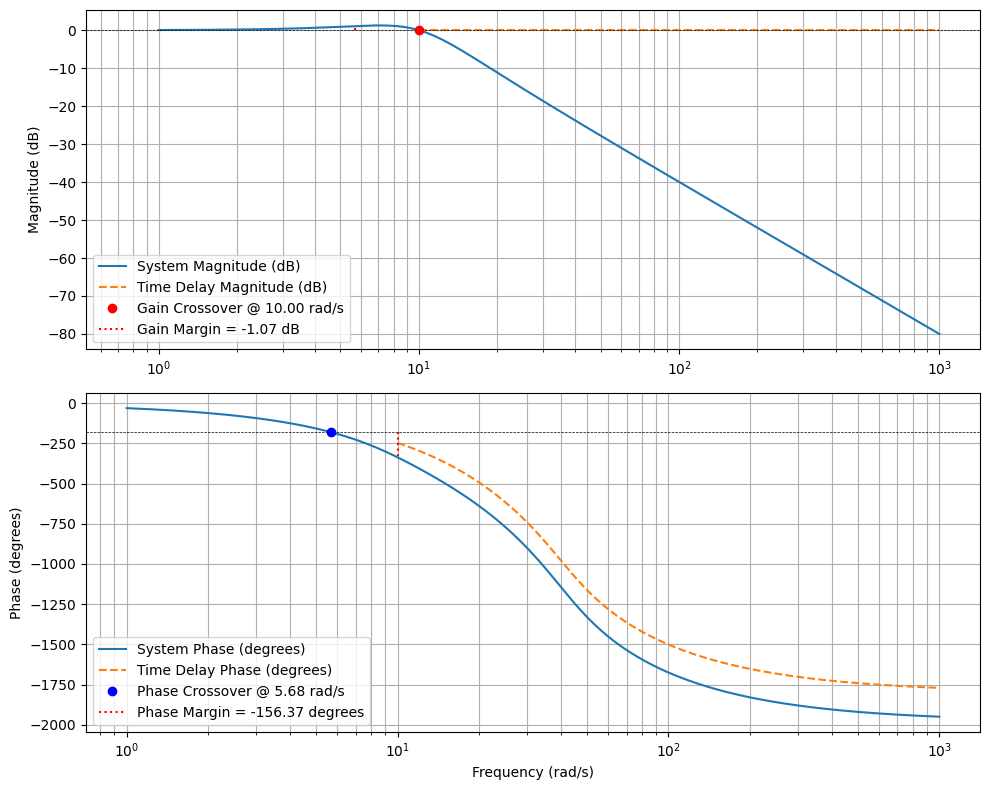

In [66]:
def bode_plot_with_margins_delay(num, den, delay_num=None, delay_den=None):
    if delay_num is not None and delay_den is not None:
        delay_sys = ct.TransferFunction(delay_num, delay_den)
        sys = ct.series(ct.TransferFunction(num, den), delay_sys)
    else:
        sys = ct.TransferFunction(num, den)

    gm, pm, wcg, wcp = ct.margin(sys)

    if delay_num is not None and delay_den is not None:
        mag_d, phase_d, omega_d = ct.bode_plot(delay_sys, dB=True, deg=True, plot=False)
        mag_d = 20 * np.log10(mag_d)
        phase_d = np.degrees(phase_d)
    else:
        mag_d, phase_d, omega_d = None, None, None

    mag, phase, omega = ct.bode_plot(sys, dB=True, deg=True, plot=False)
    mag = 20 * np.log10(mag)
    phase = np.degrees(phase)

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.semilogx(omega, mag, label='System Magnitude (dB)')
    if mag_d is not None:
        plt.semilogx(omega_d, mag_d, label='Time Delay Magnitude (dB)', linestyle='--')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

    if not np.isnan(wcp):
        plt.plot(wcp, 0, 'ro', label=f'Gain Crossover @ {wcp:.2f} rad/s')
    if gm != float('inf'):
        plt.vlines(wcg, 0, -20 * np.log10(gm), color='red', linestyle=':', label=f'Gain Margin = {20 * np.log10(gm):.2f} dB')

    plt.ylabel('Magnitude (dB)')
    plt.legend(loc='best')
    plt.grid(True, which="both")

    plt.subplot(2, 1, 2)
    plt.semilogx(omega, phase, label='System Phase (degrees)')
    if phase_d is not None:
        plt.semilogx(omega_d, phase_d, label='Time Delay Phase (degrees)', linestyle='--')

    plt.axhline(-180, color='black', linewidth=0.5, linestyle='--')

    if not np.isnan(wcg):
        plt.plot(wcg, -180, 'bo', label=f'Phase Crossover @ {wcg:.2f} rad/s')
    if pm != float('inf'):
        plt.vlines(wcp, -180, -180 + pm, color='red', linestyle=':', label=f'Phase Margin = {pm:.2f} degrees')

    plt.ylabel('Phase (degrees)')
    plt.xlabel('Frequency (rad/s)')
    plt.legend(loc='best')
    plt.grid(True, which="both")

    print("Gain Margin (dB):", 20 * np.log10(gm) if gm > 0 else 'Infinity')
    print("Phase Margin (degrees):", pm)
    print("Gain Crossover Frequency (rad/s):", wcp)
    print("Phase Crossover Frequency (rad/s):", wcg)

    plt.tight_layout()
    plt.show()

def update_bode_plot(b):
    clear_output(wait=True)
    display(widgets.VBox([numerator_text, denominator_text, delay_slider, plot_button]))

    try:
        num = [float(x) for x in numerator_text.value.split(',')]
        den = [float(x) for x in denominator_text.value.split(',')]
        delay = delay_slider.value

        delay_num, delay_den = ct.pade(delay, n=10)
        bode_plot_with_margins_delay(num, den, delay_num, delay_den)
    except ValueError:
        print("Please enter valid coefficients separated by commas.")

numerator_text = widgets.Text(value='100', description='Numerator:', placeholder='e.g., 10,4')
denominator_text = widgets.Text(value='1,10,100', description='Denominator:', placeholder='e.g., 12,30,50')

delay_slider = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=2.0,
    step=0.01,
    description='Time Delay (s):',
    continuous_update=False
)

plot_button = widgets.Button(description="Plot Bode")
plot_button.on_click(update_bode_plot)

display(widgets.VBox([numerator_text, denominator_text, delay_slider, plot_button]))


### Effect of the time delay on the Nyquist Plot

The Nyquist plot of a time delay operator is simply a unit circle. To verify this, consider a transfer function where the numerator is num=[1] and the denominator is
den=[1].
In a system, the time delay introduces a counterclockwise rotation of the Nyquist plot. This rotation becomes more pronounced as the frequency increases. As the delay increases, the system's Nyquist plot may begin to encircle the critical point (-1, 0), potentially leading to instability.

Text(value='1, 1', description='Numerator:')

Text(value='1, 2, 1', description='Denominator:')

FloatSlider(value=1.12, continuous_update=False, description='Time Delay (s):', max=5.0, step=0.01)

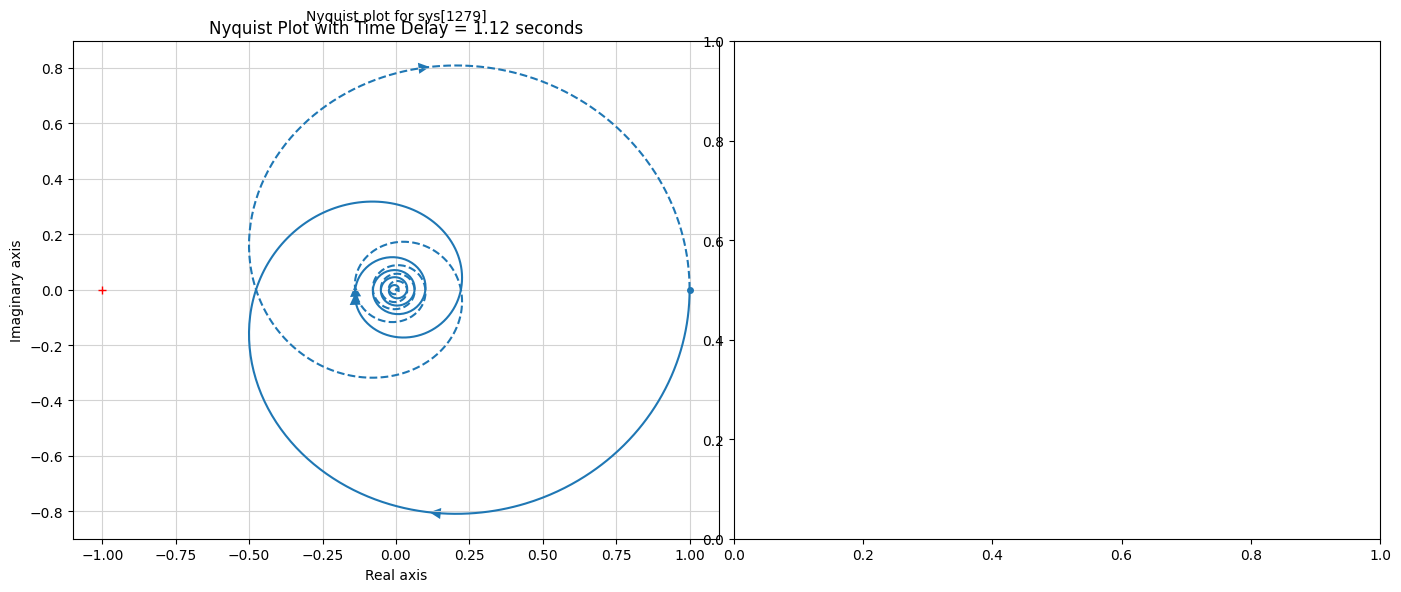

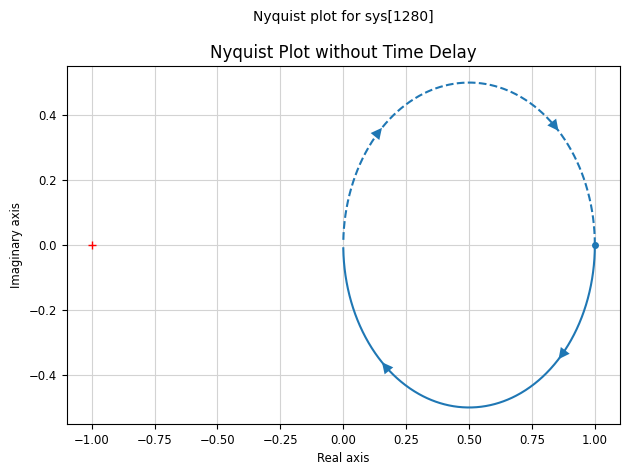

Transfer Function Numerator: [1.0, 1.0]
Transfer Function Denominator: [1.0, 2.0, 1.0]


In [67]:
def transfer_function_with_delay(num, den, delay):
    G = ct.TransferFunction(num, den)
    delay_num, delay_den = ct.pade(delay, n=10)
    G_delay = ct.TransferFunction(delay_num, delay_den)

    G_total = G * G_delay
    return G_total

def plot_nyquist(num, den, delay):
    G_total = transfer_function_with_delay(num, den, delay)

    G_no_delay = ct.TransferFunction(num, den)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    ct.nyquist_plot(G_total)
    plt.title(f"Nyquist Plot with Time Delay = {delay} seconds")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    ct.nyquist_plot(G_no_delay)
    plt.title("Nyquist Plot without Time Delay")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("Transfer Function Numerator:", num)
    print("Transfer Function Denominator:", den)

def parse_transfer_function(input_str):
    input_str = input_str.replace(' ', '')  # Remove spaces
    terms = input_str.split('+')
    num = []

    for term in terms:
        if '-' in term:
            subterms = term.split('-')
            for i, subterm in enumerate(subterms):
                if subterm:
                    if i == 0:
                        num.append('-' + subterm)
                    else:
                        num.append('-' + subterm)
        else:
            num.append(term)

    return num

num_text = widgets.Text(
    value="1, 1",
    description='Numerator:',
    disabled=False
)

den_text = widgets.Text(
    value="1, 2, 1",
    description='Denominator:',
    disabled=False
)

delay_slider = widgets.FloatSlider(
    value=0.1,
    min=0.0,
    max=5.0,
    step=0.01,
    description='Time Delay (s):',
    continuous_update=False
)

def update_plot(change):
    clear_output(wait=True)

    # Parse input transfer function values
    display(num_text, den_text, delay_slider)

    try:
        num = [float(x) for x in num_text.value.split(',')]
        den = [float(x) for x in den_text.value.split(',')]
        plot_nyquist(num, den, delay_slider.value)
    except ValueError:
        print("Please ensure numerator and denominator are comma-separated numbers.")


num_text.observe(update_plot, names='value')
den_text.observe(update_plot, names='value')
delay_slider.observe(update_plot, names='value')

display(num_text, den_text, delay_slider)
update_plot(None)

# Approximation of Time Delays

Since the term which corresponds to our time delay $e^{-sT}$ is not rational, we cannot use the root locus method. We need to approximate our time delay.

## Taylor Approximation

We can do a Taylor series expansion for, e.g., the third order:
$$e^{-sT}\approx 1-sT+\frac{1}{2}(sT)^2-\frac{1}{6}(sT)^3 \approx \frac{6-6(sT)+3(sT)^2-(sT)^3}{6}$$
We can see that this is a non-proper transfer function since the numerator polynomial has a degree of 6 and the denominator a degree of zero. Non-proper transfer functions grow without bound as frequency $s \rightarrow \infty$, which implies infinite gain at high frequencies. This makes the Taylor series expansion a bad approximation since we know the gain of the time delay is always equal to one.

## Padeé Approximation

Instead, we approximate our time delay with a ratio of polynomials. For calculating the Padeé approximation by hand, we limit ourselves to the first-order Padeé approximation, which consists of the ratio of two first-order polynomials:
$$e^{-sT} \approx k\frac{s+p}{s+q}$$

For finding the coefficients $k$, $p$, and $q$, we set the approximation equal to the Taylor series expansion:
$$k\frac{s+p}{s+q} = 1 - sT + \frac{1}{2}(sT)^2-\frac{1}{6}(sT)^3...$$

Reordering and comparing the coefficients, we get:

$ks + kp = s + q - s^2T - qsT + \frac{1}{2}s^3T^2 + \frac{1}{2}q(sT)^2...$

Order 0: $kp = q$

Order 1: $k = 1 - qT$

Order 2: $0 = -T + \frac{1}{2}qT^2$

For the first-order approximation, we calculate that:
$$q = \frac{2}{T}$$
$$k = -1$$
$$p = -\frac{2}{T}$$

Inserting this into our formula, we get:
$$e^{-sT}\approx \frac{\frac{2}{T}-s}{\frac{2}{T}+s}$$

This approximation has the advantage that the magnitude is always equal to 1.


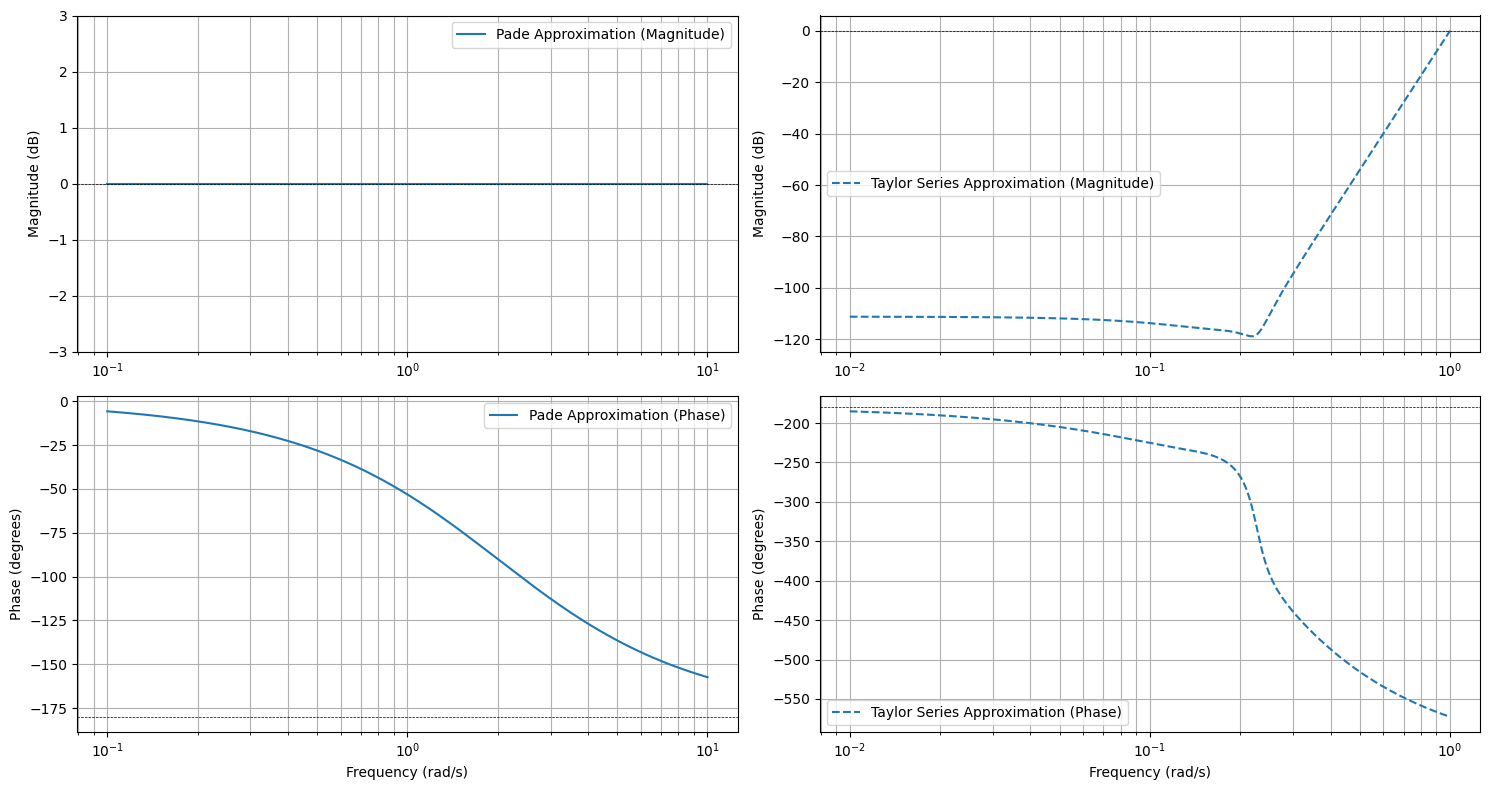

In [68]:

def taylor_series_expansion(T, degree):
    numerator_coeffs = []
    denominator_coeffs = [1]

    for n in range(degree):
        coeff = ((-1)**n * (T**n)) / math.factorial(n)
        numerator_coeffs.append(coeff)

    return numerator_coeffs, denominator_coeffs

def bode_plot_with_pade(T, degree, ax1, ax2):
    delay_num_pade, delay_den_pade = ct.pade(T, n=degree)
    delay_sys_pade = ct.TransferFunction(delay_num_pade, delay_den_pade)

    mag_pade, phase_pade, omega_pade = ct.bode_plot(delay_sys_pade, dB=True, deg=True, plot=False)
    mag_pade = 20 * np.log10(mag_pade)
    phase_pade = np.degrees(phase_pade)

    ax1.semilogx(omega_pade, mag_pade, label='Pade Approximation (Magnitude)', linestyle='-')
    ax1.set_ylim(-3, 3)
    ax1.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax1.set_ylabel('Magnitude (dB)')
    ax1.legend(loc='best')
    ax1.grid(True, which="both")

    ax2.semilogx(omega_pade, phase_pade, label='Pade Approximation (Phase)', linestyle='-')
    ax2.axhline(-180, color='black', linewidth=0.5, linestyle='--')
    ax2.set_ylabel('Phase (degrees)')
    ax2.set_xlabel('Frequency (rad/s)')
    ax2.legend(loc='best')
    ax2.grid(True, which="both")

def bode_plot_with_taylor(T, degree, ax1, ax2):
    # Taylor series approximation
    num_coeffs_taylor, den_coeffs_taylor = taylor_series_expansion(T, degree)
    delay_sys_taylor = ct.TransferFunction(num_coeffs_taylor, den_coeffs_taylor)

    mag_taylor, phase_taylor, omega_taylor = ct.bode_plot(delay_sys_taylor, dB=True, deg=True, plot=False)
    mag_taylor = 20 * np.log10(mag_taylor)
    phase_taylor = np.degrees(phase_taylor)

    ax1.semilogx(omega_taylor, mag_taylor, label='Taylor Series Approximation (Magnitude)', linestyle='--')
    ax1.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax1.set_ylabel('Magnitude (dB)')
    ax1.legend(loc='best')
    ax1.grid(True, which="both")

    ax2.semilogx(omega_taylor, phase_taylor, label='Taylor Series Approximation (Phase)', linestyle='--')
    ax2.axhline(-180, color='black', linewidth=0.5, linestyle='--')
    ax2.set_ylabel('Phase (degrees)')
    ax2.set_xlabel('Frequency (rad/s)')
    ax2.legend(loc='best')
    ax2.grid(True, which="both")

def update_bode_plot(b):
    clear_output(wait=True)
    display(widgets.VBox([delay_slider_pade, degree_slider_pade, delay_slider_taylor, degree_slider_taylor, plot_button]))

    try:
        T_pade = delay_slider_pade.value
        degree_pade = int(degree_slider_pade.value)
        T_taylor = delay_slider_taylor.value
        degree_taylor = int(degree_slider_taylor.value)

        fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 8))

        bode_plot_with_pade(T_pade, degree_pade, ax1[0], ax2[0])

        bode_plot_with_taylor(T_taylor, degree_taylor, ax1[1], ax2[1])

        plt.tight_layout()
        plt.show()

    except ValueError:
        print("Please enter valid coefficients separated by commas.")

delay_slider_pade = widgets.FloatSlider(
    value=1.0,
    min=0.01,
    max=2.0,
    step=0.01,
    description='Pade Time Delay (s):',
    continuous_update=False
)

degree_slider_pade = widgets.IntSlider(
    value=10,
    min=1,
    max=20,
    step=1,
    description='Pade Degree:'
)

delay_slider_taylor = widgets.FloatSlider(
    value=1.0,
    min=0.01,
    max=2.0,
    step=0.01,
    description='Taylor Time Delay (s):',
    continuous_update=False
)

degree_slider_taylor = widgets.IntSlider(
    value=10,
    min=1,
    max=20,
    step=1,
    description='Taylor Degree:'
)

plot_button = widgets.Button(description="Plot Bode")
plot_button.on_click(update_bode_plot)

# Display widgets for interaction
display(widgets.VBox([delay_slider_pade, degree_slider_pade, delay_slider_taylor, degree_slider_taylor, plot_button]))


## Example

We want to use the root locus method to design a controller for our simple $\frac{1}{s+1}$ system, but we have a delay of 0.5 seconds inside our system. How do we approximate the time delay as a rational function which we can use for the root locus method?

First, we calculate the Padeé approximation using the formula we derived before:

$$e^{-0.5s} \approx \frac{1-0.25s}{1+0.25s}$$

Now we modify our plant transfer function to:
$$P(s) = \frac{1-0.25s}{1+0.25s} \cdot \frac{1}{s+1}$$

and use a proportional controller $C(s) = K_p$.

Since the transfer function of the Padeé approximation has a non-minimum phase zero, as we increase our gain, the system can become unstable. Note that this is an approximation.


In [69]:

def plot_root_locus(num, den, time_delay, pade_order):
    num = [float(n) for n in num.split(',')]
    den = [float(d) for d in den.split(',')]

    pade_order = int(pade_order)

    plant = ct.TransferFunction(num, den)

    pade_num, pade_den = ct.pade(time_delay, pade_order)

    pade_transfer_function = ct.TransferFunction(pade_num, pade_den)

    system_with_delay = plant * pade_transfer_function

    plt.figure(figsize=(8, 6))
    ct.root_locus(system_with_delay)
    plt.title(f"Root Locus with Time Delay {time_delay}s and Pade Order {pade_order}")
    plt.show()

time_delay_slider = FloatSlider(value=0.5, min=0, max=5, step=0.1, description='Time Delay (s):')
pade_order_slider = FloatSlider(value=1, min=1, max=10, step=1, description='Pade Approx Order:')

num_input = widgets.Text(value='1', description='Numerator:')
den_input = widgets.Text(value='1,1', description='Denominator:')

interactive_plot = interactive(plot_root_locus,
                               num=num_input,
                               den=den_input,
                               time_delay=time_delay_slider,
                               pade_order=pade_order_slider)

display(interactive_plot)


interactive(children=(Text(value='1', description='Numerator:'), Text(value='1,1', description='Denominator:')…